In [74]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import io
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [75]:
train = pd.read_csv("../input/titanic-ds/train.csv")
test = pd.read_csv("../input/titanic-ds/test.csv")
pids = test['PassengerId']

In [76]:
train['TT'] = train['Ticket'].apply(lambda x: x[0:3])
train['TT'] = train['TT'].astype('category')
train['TT'] = train['TT'].cat.codes
test['TT'] = test['Ticket'].apply(lambda x: x[0:3])
test['TT'] = test['TT'].astype('category')
test['TT'] = test['TT'].cat.codes

In [77]:
full_set = [train, test]

In [78]:
train['Cabin_YN'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Cabin_YN'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

In [79]:
for dataset in full_set:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Embarked'] = dataset['Embarked'].fillna("S")
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [80]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [81]:
for data in full_set:
    avg_age = data['Age'].mean()
    std_age = data['Age'].std()
    null_count = data['Age'].isnull().sum()
    null_rands = np.random.randint(avg_age - std_age, avg_age + std_age, size=null_count)
    data['Age'][np.isnan(data['Age'])] = null_rands
    data['Age'] = data['Age'].astype(int)

In [82]:
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [83]:
def extract_title(name):
    search = re.search(' ([A-Za-z]+)\.', name)
    if search:
        return search.group(1)
    return ""

In [84]:
hons = ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]
title_dict = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
emb_dict = {"S":0, "C":1, "Q":2}

In [85]:
for data in full_set:
    data['Title'] = data['Name'].apply(extract_title)
    data['Title'] = data['Title'].replace(hons, "Rare")
    data['Title'] = data['Title'].replace("Mlle", "Miss")
    data['Title'] = data['Title'].replace("Ms", "Miss")
    data['Title'] = data['Title'].replace("Mme", "Mrs")
    data['Title'] = data['Title'].map(title_dict)
    data['Title'] = data['Title'].fillna(0)
    data['Sex'] = data['Sex'].map({"female":0, "male":1})

In [86]:
for data in full_set:
    data['Embarked'] = data['Embarked'].map(emb_dict)
    data.loc[(data['Fare'] <= 7.91), "Fare"] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), "Fare"] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), "Fare"] = 2
    data.loc[data['Fare'] > 31, "Fare"] = 3
    data['Fare'].astype(int)
    data.loc[data['Age'] <= 16, "Age"] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), "Age"] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), "Age"] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), "Age"] = 3
    data.loc[data['Age'] > 64, "Age"] = 4

In [87]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(to_drop, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(to_drop, axis=1)

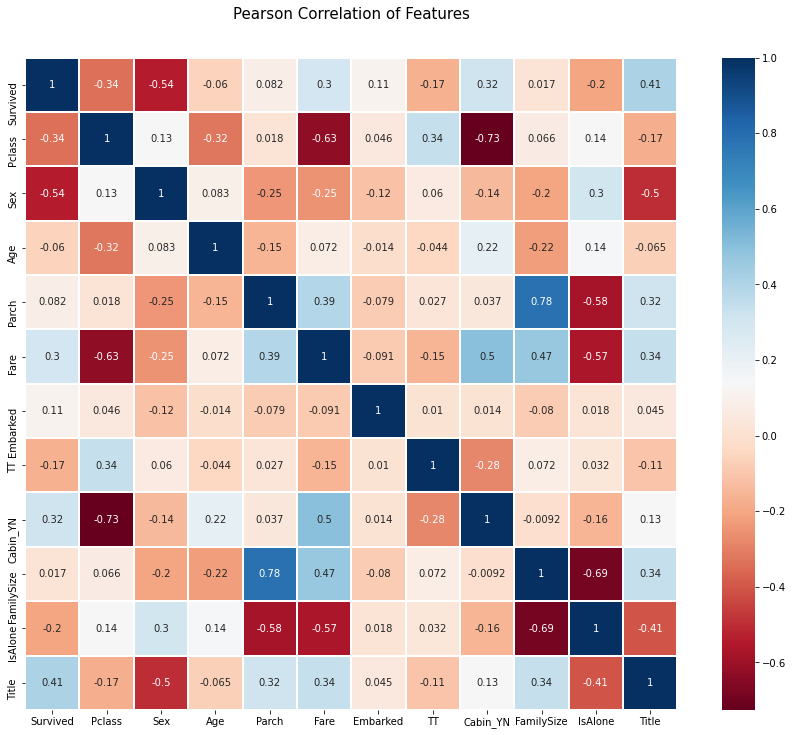

In [88]:
cols = plt.cm.RdBu
plt.figure(figsize=(16,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=cols, linecolor='white', annot=True)
plt.show()

In [89]:
y_train = train['Survived'].ravel()
train = train.drop("Survived", axis=1)
X_train = train.values
X_test = test.values

In [90]:
xgb = XGBClassifier(learning_rate=0.02, eval_metric="logloss", n_estimators=2000, max_depth=4, min_child_weight=2, gamma=0.9, subsample=0.8, colsample_bytree=0.8, objective="binary:logistic", nthread=-1, scale_pos_weight=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0.9, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=4,
              nthread=-1, num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
predictions = xgb.predict(X_test)

In [92]:
submit_one = pd.DataFrame({"PassengerId":pids, "Survived":predictions})
submit_one.to_csv("Titanic_82721_III.csv", index=False)

In [93]:
df1 = pd.read_csv("../input/comparative-data/g_a.csv")
df2 = pd.read_csv("../input/comparative-data/submission_GA.csv")
df3 = pd.read_csv("../input/comparative-data/g_a.csv")
X1 = 0.4
X2 = 0.3

In [101]:
ensemble = df1.copy()
K = "Survived"
ensemble[K] = X1*df1[K] + X2*df2[K] + (1-X1-X2) * submit_one[K]
ensemble[K] = ensemble[K].apply(lambda f: 1 if f >= 0.5 else 0)
ensemble.to_csv("Ensemble_82821_IV.csv", index=False)